Copyright (C) 2022 Glencoe Software, Inc. All Rights Reserved.

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.

# Basic OMERO API calls in python

* Connect to OMERO server
* List images in the Dataset
* Show image metadata
* Render image
* Show raw image planes
* Find images using key-value pairs

### Connect to the OMERO server

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

from IPython.display import display, HTML

In [2]:
import omero
from omero.gateway import BlitzGateway

import pprint

In [3]:
from getpass import getpass
conn = BlitzGateway(
    input("Username: "), getpass("OMERO Password: "),
    host=input("Host: "), port=int(input("Port: ")))
conn.connect()

True


### User info

In [4]:
user = conn.getUser()
print("Current user:")
print("   ID:", user.getId())
print("   Username:", user.getName())
print("   Full Name:", user.getFullName())
print("Member of:")
for g in conn.getGroupsMemberOf():
    print(f"   ID:{g.getName()} Name: {g.getId()}")
group = conn.getGroupFromContext()
print(f"Current group: {group.getName()}")

Current user:
   ID: 52
   Username: demo.user
   Full Name: Demo User
Member of:
   ID:Demo Group Name: 3
Current group: Demo Group


### Dataset listing

In [5]:
dataset_id = 56
dataset = conn.getObject("Dataset", dataset_id)
print(f"Images in Dataset: {dataset.getName()}")
for image in dataset.listChildren():
    print(f"  Name: {image.name}, Id: {image.id}")

Images in Dataset: 3D and 4D Fluorescence
  Name: Fig4B_Bod1si.dv, Id: 1130
  Name: Fig4D_left.dv, Id: 1131
  Name: Fig4D_middle.dv, Id: 1132
  Name: Fig4D_right.dv, Id: 1133


### Image metadata

In [6]:
image_id = 1131
image = conn.getObject("Image", image_id)
print(f"\nImage:{image_id}")
print("=" * 50)
print(image.getName(), image.getDescription())
# Retrieve information about an image.
print(f"  Size X: {image.getSizeX()}")
print(f"  Size Y: {image.getSizeY()}")
print(f"  Size Z: {image.getSizeZ()}")
print(f"  Size C: {image.getSizeC()}")
print(f"  Size T: {image.getSizeT()}")


Image:1131
Fig4D_left.dv 
  Size X: 337
  Size Y: 340
  Size Z: 54
  Size C: 4
  Size T: 1


### Render image

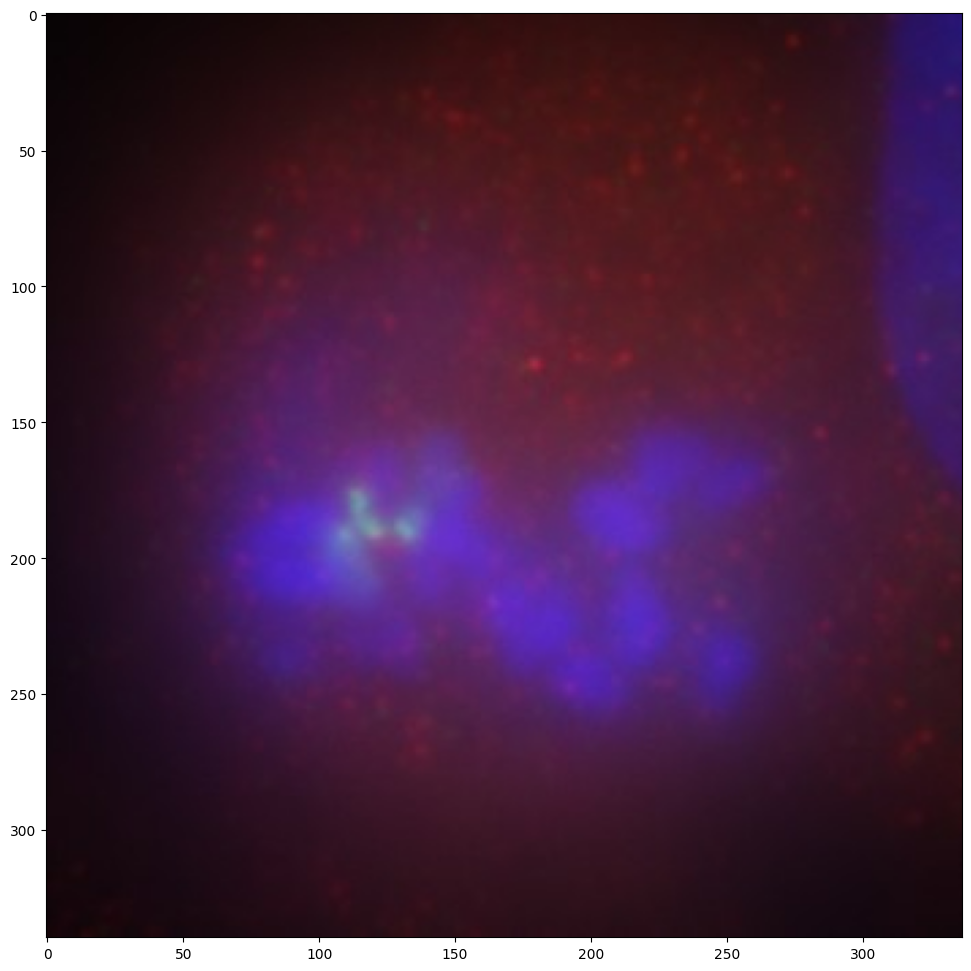

In [8]:
z = 0
t = 0
renderedImage = image.renderImage(z, t)
fig = plt.figure()
plt.imshow(renderedImage);

### Raw image planes

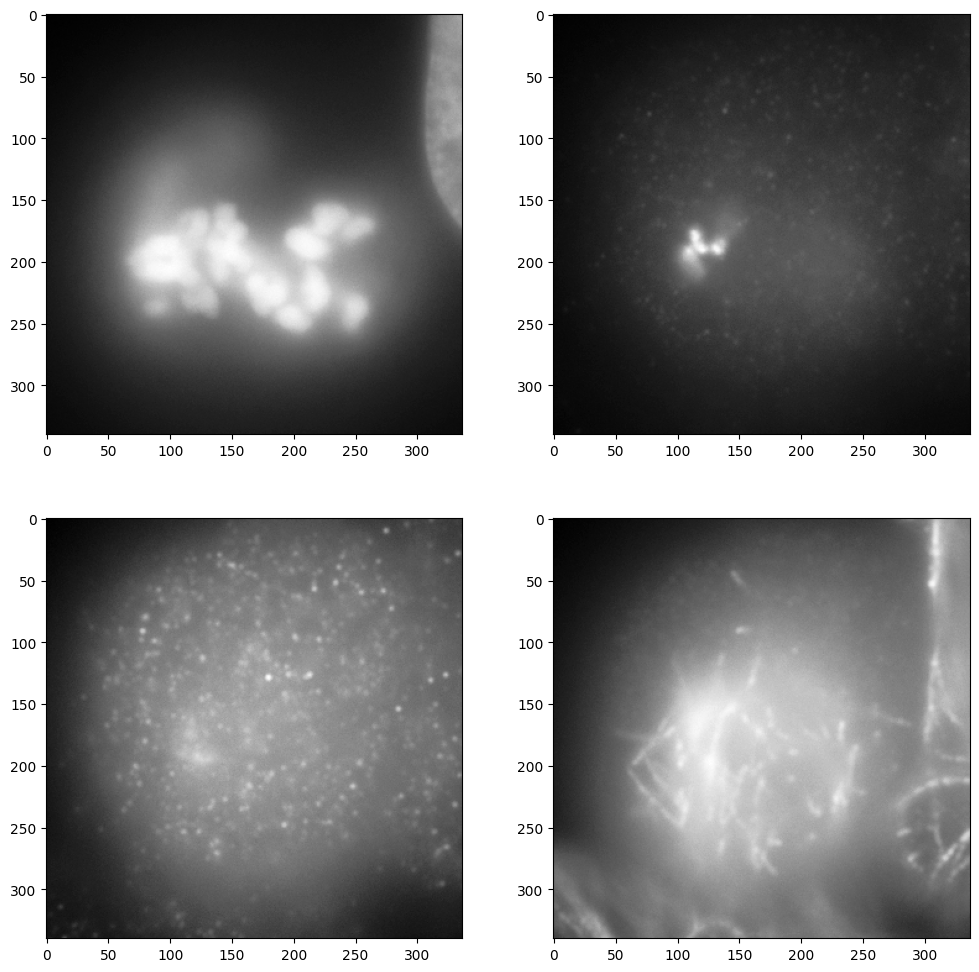

In [9]:
pixels = image.getPrimaryPixels()
planes = []
fig = plt.figure()
for channel in range(4):
    planes.append(pixels.getPlane(z, channel, t))
    ax = fig.add_subplot(2, 2, channel + 1)
    plt.imshow(planes[channel], cmap='Greys_r')

### Query Service

In [26]:
key = "Tumor Stage"
value = "Stage iv"

query = '''
    SELECT image.name, ma.name, ma.value FROM Image AS image 
    LEFT OUTER JOIN image.annotationLinks as links
    LEFT OUTER JOIN links.child as annotation 
    LEFT OUTER JOIN annotation.mapValue as ma 
    WHERE annotation MEMBER OF MapAnnotation 
    AND ma.name = :key AND ma.value = :value
    '''

params = omero.sys.ParametersI()
params.add("key", omero.rtypes.rstring(key))
params.add("value", omero.rtypes.rstring(value))
query_service = conn.getQueryService()
image_names = query_service.projection(query, params)
print(f"Found {len(image_names)} images")
for image_name in image_names:
    print(f"  {image_name[0].val}")

Found 15 images
  TCGA-OR-A5JJ-01A-01-TS1.6ED1CED7-C51F-4A0E-AA37-8052E1CD3C7A.svs [0]
  TCGA-OR-A5J2-01A-01-TS1.F951E65D-4231-4880-83AB-D17520D1AC95.svs [0]
  TCGA-OR-A5LJ-01A-01-TSA.74CF9AC7-9BCD-455B-8270-A5D0D739F282.svs [0]
  TCGA-OR-A5KY-01A-01-TS1.C547B18A-707A-43B9-85B4-248D7C49FE9C.svs [0]
  TCGA-OR-A5JY-01A-03-TS3.379E24E0-0700-49C2-8B81-B5A1713BDF67.svs [0]
  TCGA-OR-A5JK-01A-01-TS1.B4058DB1-3128-4392-98F2-BF17E395C312.svs [0]
  TCGA-OR-A5JB-01A-01-TS1.B68B5BAF-B262-4DAA-9F47-A285B3C497AF.svs [0]
  TCGA-OR-A5JM-01A-01-TSA.5BAF7C4F-A981-469D-9D1D-44D936D8538D.svs [0]
  TCGA-OR-A5LB-01A-01-TS1.B32D5A9D-9448-4321-A499-2EC543FEFD3D.svs [0]
  TCGA-P6-A5OG-01A-02-TS2.2CAA26CF-82D8-410A-94A1-C1F20AEB61CA.svs [0]
  TCGA-OR-A5JA-01A-01-TSA.E0FCA5E9-E5EE-4A9B-9D8D-DE6A4481A739.svs [0]
  TCGA-OR-A5J4-01A-01-TS1.3518A147-99D6-49EF-A4A2-C5803E3D2234.svs [0]
  TCGA-OR-A5KO-01A-01-TS1.2EC986BB-D9FE-4001-8384-067144E41FB1.svs [0]
  TCGA-OR-A5JG-01A-01-TS1.6D8C9756-F183-4055-9A3D-8B4F860743C